In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

from pyproj import CRS, Transformer
from PIL import Image, ImageFont
from PIL.ImageDraw import Draw
from io import BytesIO
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import transform

/home/rohit/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
DATA_FILE = "data/san-francisco/gis_osm_buildings_a_free_1.shx"
#CENTER = 2.29504, 48.86826 # paris
CENTER = -122.39753, 37.7954 # san francisco
#CENTER = 12.3308, 45.4343 # venice
V_RES = 6144*2
H_RES = int(V_RES*2/3)
CITY_NAME = "san francisco"


HORIZ_RADIUS = 1600
VERT_RADIUS = 3*HORIZ_RADIUS/2
MAIN_OFFSET = (650/6144)*V_RES
SUBTITLE1_OFFSET = (500/6144)*V_RES
BOX_START_OFFSET = (650/6144)*V_RES
BOX_END_OFFSET = (425/6144)*V_RES
BOX_X_START = (150/6144)*V_RES
BOX_WIDTH = (len(" ".join(CITY_NAME))*90/ 6144)*V_RES
TITLE_FONT = ImageFont.truetype("fonts/FiraCode.ttf", size=int((128/6144)*V_RES))
SUBTITLE_FONT = ImageFont.truetype("fonts/FiraCode.ttf", size=int((48/6144)*V_RES))

In [3]:
%%time
try:
    p_df
except NameError:
    df = gpd.read_file(DATA_FILE)
    p_df = df.to_crs(epsg=3395)

CPU times: user 1min 43s, sys: 2.2 s, total: 1min 46s
Wall time: 1min 46s


In [4]:
%%time
p_df.sindex

CPU times: user 581 ms, sys: 87.8 ms, total: 669 ms
Wall time: 668 ms


In [5]:
tx = Transformer.from_crs('EPSG:4326', 'EPSG:3395', always_xy=True)

In [6]:
cx, cy = tx.transform(*CENTER)
p_w, p_e = cx - HORIZ_RADIUS, cx + HORIZ_RADIUS
p_s, p_n = cy - VERT_RADIUS, cy + VERT_RADIUS
p_bbox = p_w, p_s, p_e, p_n
assert p_w <= p_e
assert p_s <= p_n

In [7]:
possible_matches = list(p_df.sindex.intersection(p_bbox))
p_sub_df = p_df.iloc[possible_matches]

In [8]:
def rasterize_geometry(geometry, bbox):
    w, s, e, n = bbox
    assert w <= e
    assert s <= n
    y_res = V_RES
    sf = (e-w)/(n-s)
    x_res = int(sf*y_res)

    def imgspace_transform(xs, ys):
        """
        Given a set of x and y coordinates, convert them to pixels within the current image.
        """
        nonlocal w, s, e, n, x_res, y_res
        xs = np.array(xs)
        ys = np.array(ys)
        xs -= w
        ys -= s
        xs /= e - w
        ys /= n - s
        xs *= x_res
        ys *= y_res
        ys = y_res-ys
        return xs.astype(np.int64), ys.astype(np.int64)

    st, *_ = geometry
    img_geometry = [transform(imgspace_transform, shape) for shape in geometry]
    img_geometry = [list(poly) if type(poly) == MultiPolygon else poly for poly in img_geometry]
    tmp_img_geometry = []
    for poly in img_geometry:
        if type(poly) == list:
            tmp_img_geometry += poly
        else:
            tmp_img_geometry += [poly]
    img_geometry = tmp_img_geometry

    img = Image.new("L", (x_res, y_res))
    draw = Draw(img)
    for polygon in img_geometry:
        if type(polygon) != Polygon:
            print(f"Skipping non-polygon {type(polygon)}!")
            continue
        draw.polygon(list(polygon.exterior.coords), fill=1)
        for interior_hole in polygon.interiors:
            draw.polygon(list(interior_hole.coords), fill=0)

    return img, draw

def dms(cx, cy):
    ordx = "E" if cx >= 0 else "W"
    ordy = "N" if cy >= 0 else "S"    
    cx, cy = abs(cx), abs(cy)
    degx, degy = int(cx), int(cy)
    cx, cy = cx - degx, cy - degy
    minx, miny = int(60*cx), int(60*cy)
    cx, cy = cx - minx/60, cy - miny/60
    secx, secy = int(3600*cx), int(3600*cy)
    return f"{degy}° {miny}' {secy}\" {ordy}, {degx}° {minx}' {secx}\" {ordx}"

In [9]:
img, draw = rasterize_geometry(p_sub_df.geometry, p_bbox)
im_h, im_w = np.array(img).shape
name = " ".join(CITY_NAME.upper())

tw, _ = draw.textsize(name, font=TITLE_FONT)
tw = max(tw, draw.textsize(f"{dms(*CENTER)}   │   M E R C A T O R    3 3 9 5", font=SUBTITLE_FONT)[0])
draw.rectangle(((0, im_h-BOX_START_OFFSET), (150+tw+20, im_h-BOX_END_OFFSET)), fill=0, outline=1)

draw.text((150, im_h-MAIN_OFFSET), name, fill=1, font=TITLE_FONT)
draw.text((150, im_h-SUBTITLE1_OFFSET), f"{dms(*CENTER)}   │   M E R C A T O R    3 3 9 5", fill=1, font=SUBTITLE_FONT)

img = np.array(img)
new_img = np.zeros((im_h, im_w, 3), dtype=img.dtype)
new_img[:,:,0] = img*255
new_img[:, :3, :] = 0
new_img[:, -3:, :] = 0
new_img[:3, :, :] = 0
new_img[-3:, :, :] = 0
new_img[:, :3, 1] = 255
new_img[:, -3:, 1] = 255
new_img[:3, :, 1] = 255
new_img[-3:, :, 1] = 255
img = new_img

<ipython-input-8-382c8ac73fdd>:27: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  img_geometry = [list(poly) if type(poly) == MultiPolygon else poly for poly in img_geometry]
<ipython-input-8-382c8ac73fdd>:27: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  img_geometry = [list(poly) if type(poly) == MultiPolygon else poly for poly in img_geometry]


(12288, 8192, 3)


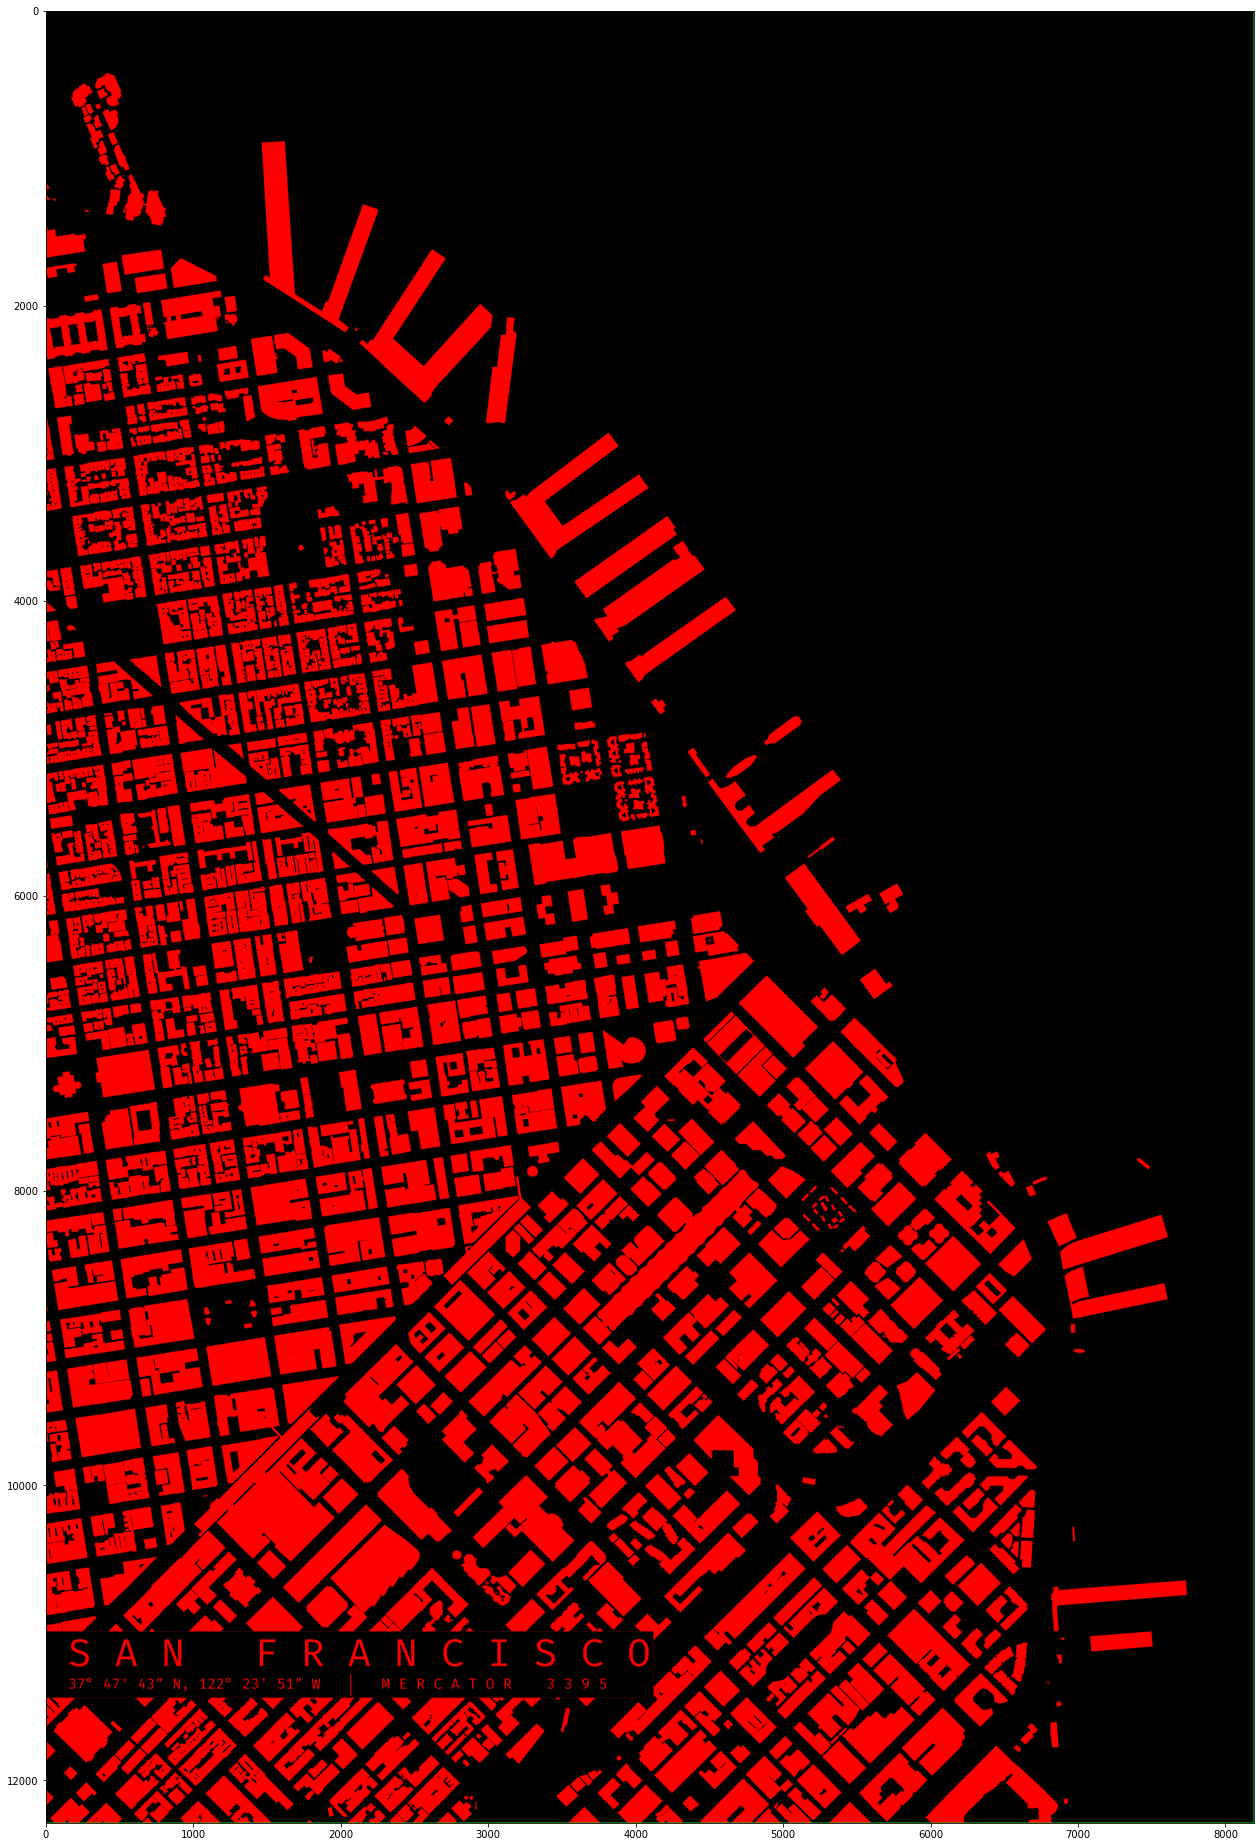

In [10]:
plt.figure(figsize=(50, 50*im_w/im_h))
plt.imshow(img, cmap='binary')
print(img.shape)
plt.show()
plt.imsave(f"{CITY_NAME}.png", img, cmap='binary')